## Structured Mask Creation

In [5]:
import os, shutil
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tqdm import tqdm

In [6]:
base_dir = os.path.expanduser('./Data')
image_dir = os.path.join(base_dir, 'clean_128')
image_filenames = sorted([
    f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))
])

mask_levels = ['25', '50', '75']
target_levels = {'25': 0.25, '50': 0.50, '75': 0.75}

def setup_mask_dirs(base_mask_name):
    mask_paths = {}
    for level in mask_levels:
        full_path = os.path.join(base_dir, f"{base_mask_name}_{level}")
        if os.path.exists(full_path):
            shutil.rmtree(full_path)
        os.makedirs(full_path)
        mask_paths[level] = full_path
    return mask_paths

edge_dirs = setup_mask_dirs("masks_edge")
structured_dirs = {
    'e': setup_mask_dirs("masks_structured-e"),
    'nm': setup_mask_dirs("masks_structured-nm"),
    'all': setup_mask_dirs("masks_structured-all")
}

In [7]:
def get_dilated_to_target(mask, target_pct, img_shape=(128, 128), max_k=25):
    for k in range(1, max_k + 1):
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
        dilated = cv2.dilate(mask, kernel, iterations=1)
        coverage = np.count_nonzero(dilated) / (img_shape[0] * img_shape[1])
        if coverage >= target_pct:
            return dilated
    return dilated  # fallback to last dilation

### A. Edge Masks (Sobel)

In [8]:
def generate_edge_mask(img_gray):
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=5)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    norm_mag = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    _, edge_mask = cv2.threshold(norm_mag.astype(np.uint8), 50, 255, cv2.THRESH_BINARY)
    return edge_mask

for fname in tqdm(image_filenames, desc="Edge masks"):
    img_path = os.path.join(image_dir, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = generate_edge_mask(gray)
    
    for level, target_pct in target_levels.items():
        dilated = get_dilated_to_target(mask, target_pct)
        cv2.imwrite(os.path.join(edge_dirs[level], fname), dilated)


Edge masks: 100%|██████████| 44376/44376 [01:35<00:00, 464.89it/s]


### B. Semantic Masks (Mediapipe)

In [9]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True)

MP_LANDMARKS = {
    'left_eye': [463, 398, 384, 385, 386, 387, 388, 466, 263, 249, 390, 373, 374, 380, 381, 382, 362], 
    'right_eye': [33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7], 
    'nose': [193, 168, 417, 122, 351, 196, 419, 3, 248, 236, 456, 198, 420, 131, 360, 49, 279, 48, 278, 219, 439, 59, 289, 218, 438, 237, 457, 44, 19, 274],
    'mouth': [0, 267, 269, 270, 409, 306, 375, 321, 405, 314, 17, 84, 181, 91, 146, 61, 185, 40, 39, 37]
}
REGION_SETS = {
    'e': ['left_eye', 'right_eye'],
    'nm': ['nose', 'mouth'],
    'all': ['left_eye', 'right_eye', 'nose', 'mouth']
}

def create_semantic_mask(img_rgb, landmarks, regions):
    h, w = img_rgb.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    for region in regions:
        indices = MP_LANDMARKS[region]
        pts = np.array([[int(landmarks.landmark[i].x * w), int(landmarks.landmark[i].y * h)] for i in indices])
        if pts.size:
            cv2.fillConvexPoly(mask, pts, 255)
    return mask

for fname in tqdm(image_filenames, desc="Structured masks"):
    img_path = os.path.join(image_dir, fname)
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    if not results.multi_face_landmarks:
        continue
    lm = results.multi_face_landmarks[0]

    for tag, regions in REGION_SETS.items():
        base_mask = create_semantic_mask(img_rgb, lm, regions)
        for level, target_pct in target_levels.items():
            dilated = get_dilated_to_target(base_mask, target_pct)
            cv2.imwrite(os.path.join(structured_dirs[tag][level], fname), dilated)


I0000 00:00:1753423301.947506 8543835 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
Structured masks:   0%|          | 0/44376 [00:00<?, ?it/s]W0000 00:00:1753423301.950895 9483269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753423301.959816 9483267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753423301.963245 9483260 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Structured masks: 100%|██████████| 44376/44376 [17:18<00:00, 42.72it/s]


### C. Viz / Sum Stats

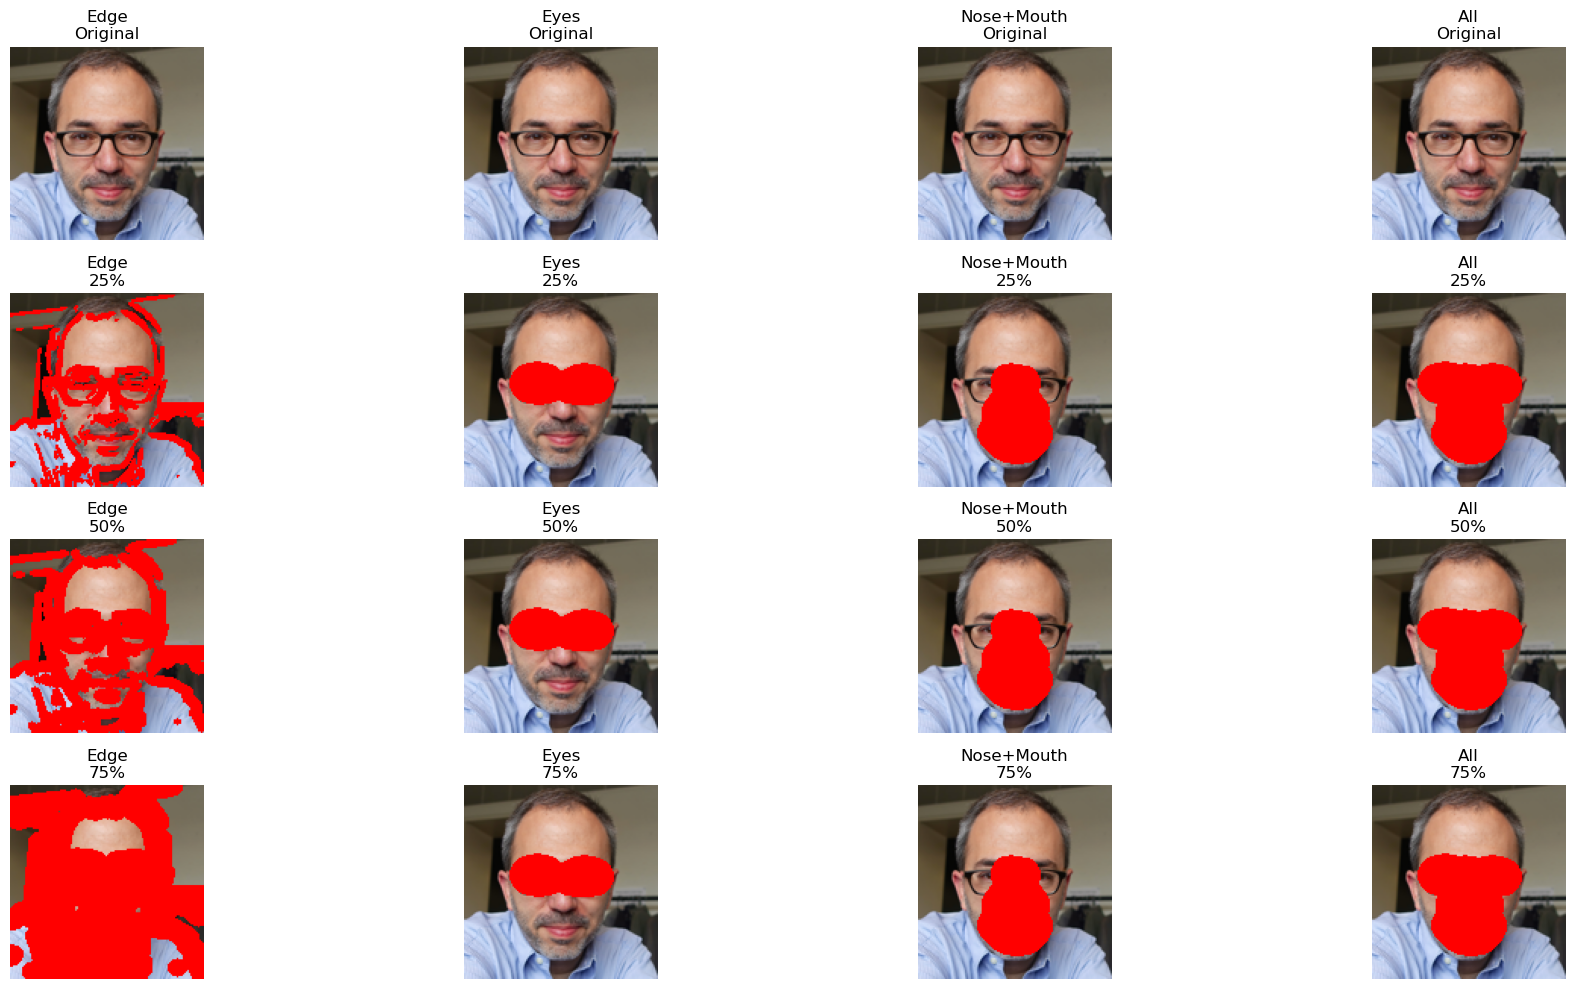

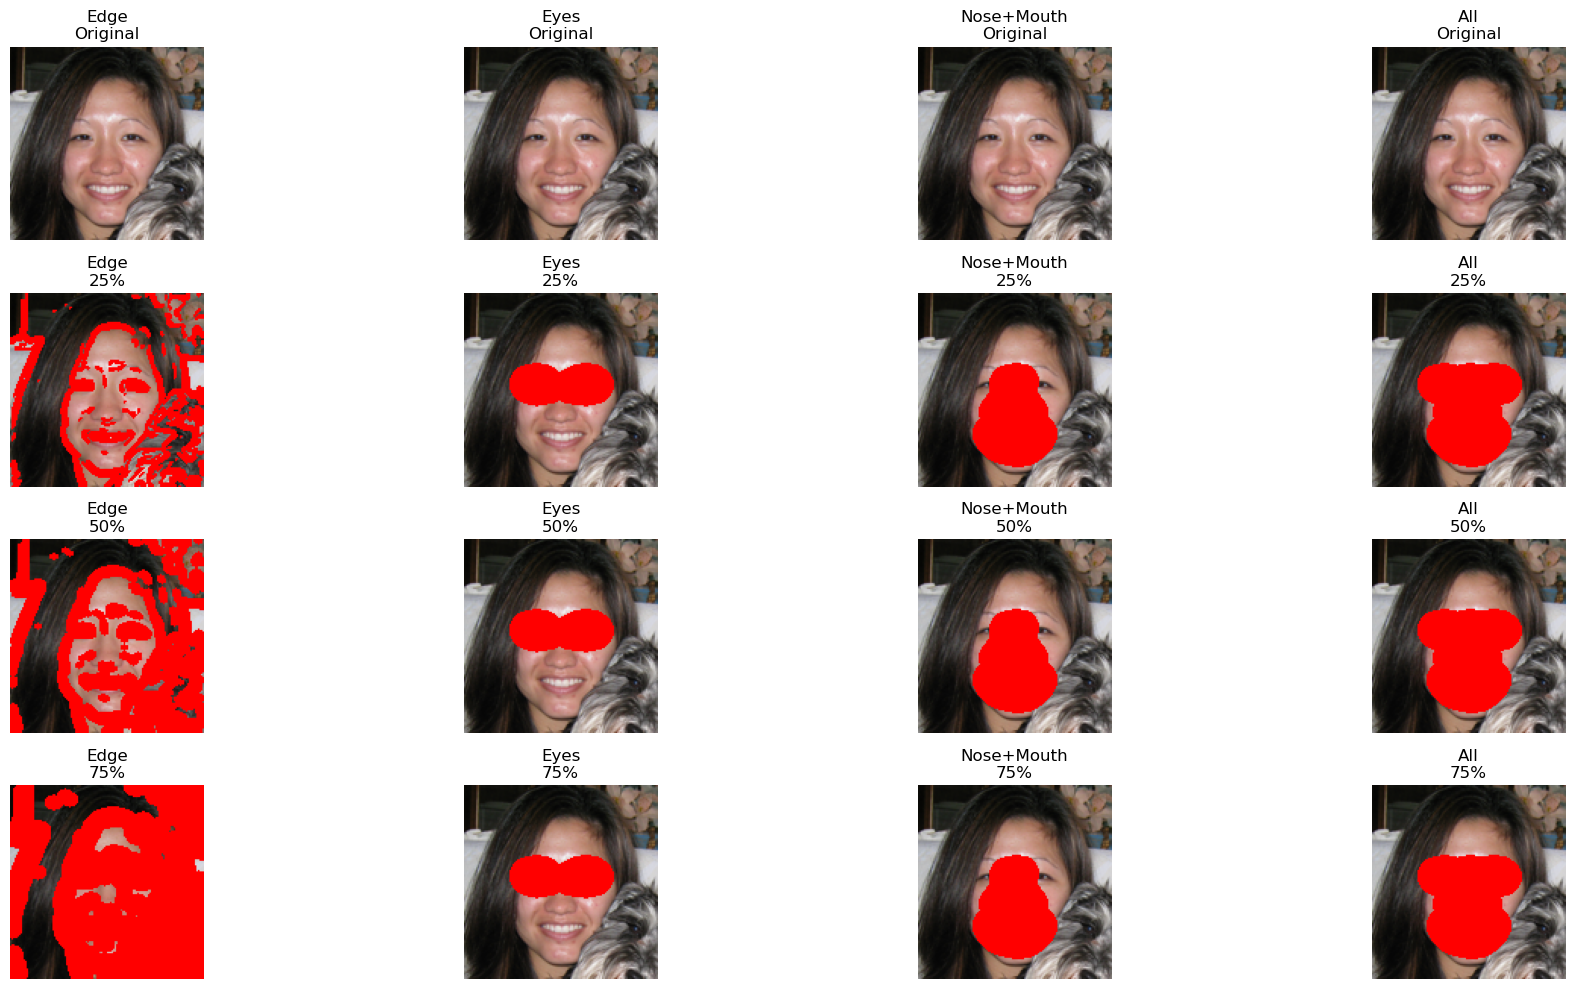

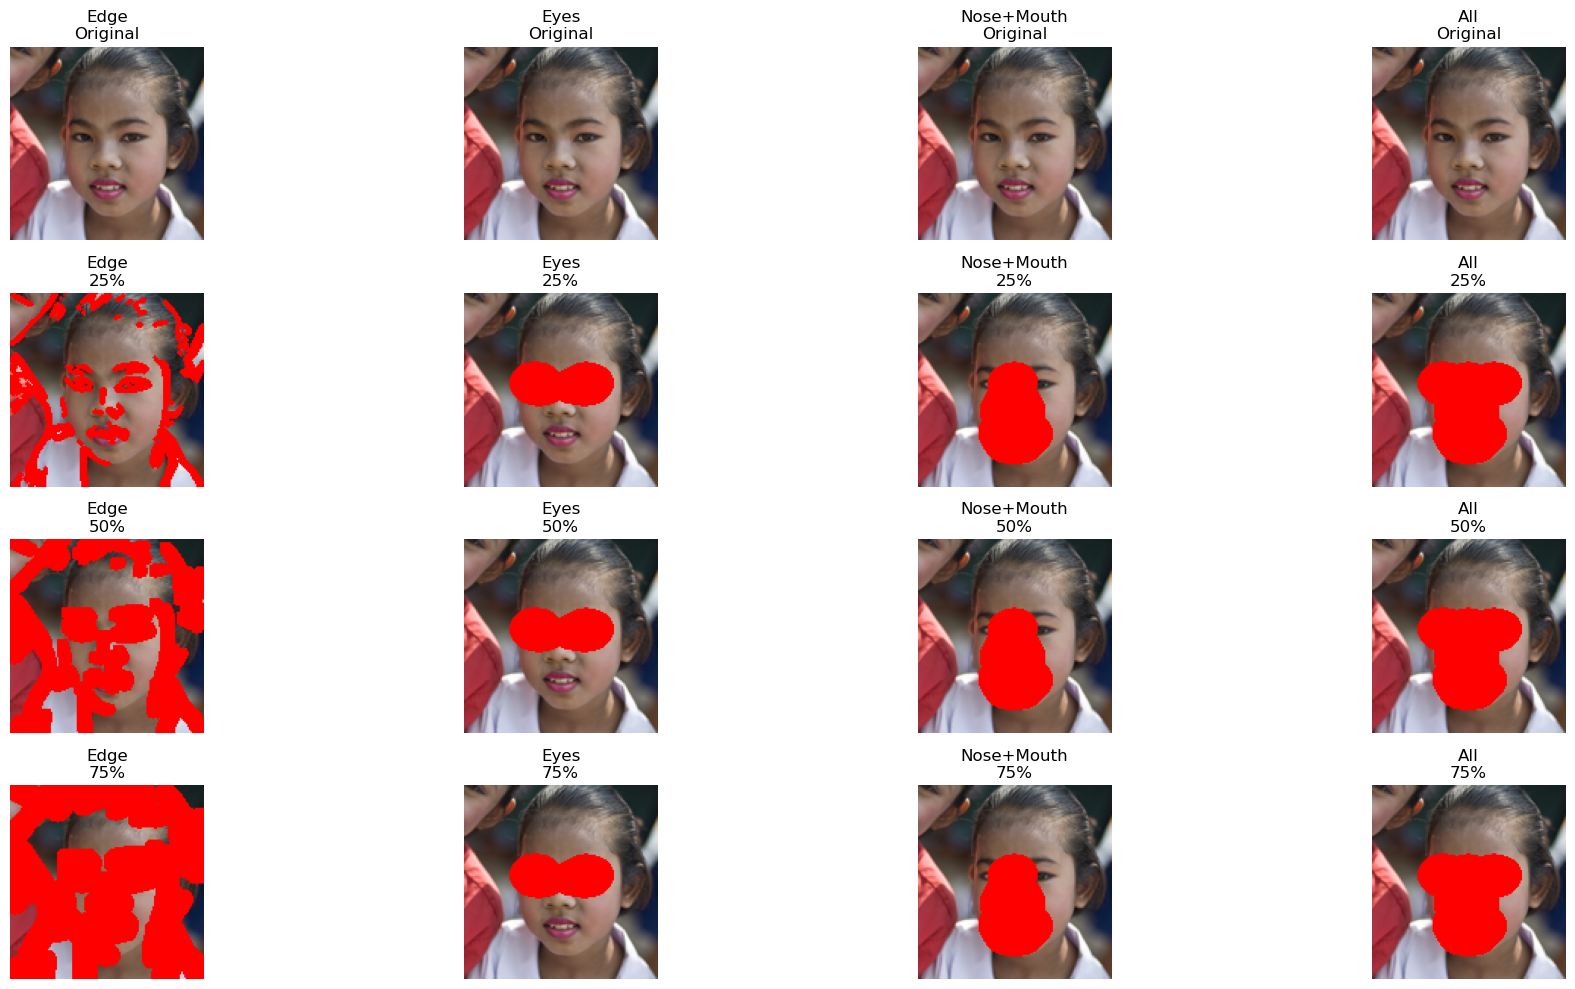

In [10]:
sample_fnames = random.sample(image_filenames, 3)

def plot_mask_comparison_with_levels(img_dir, base_mask_dirs_dict, fname):
    fig, axs = plt.subplots(len(mask_levels) + 1, len(base_mask_dirs_dict), figsize=(20, 10))
    img = cv2.imread(os.path.join(img_dir, fname))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for col, (strategy_name, level_dirs) in enumerate(base_mask_dirs_dict.items()):
        for row, level in enumerate(['orig'] + mask_levels):
            axs[row, col].axis('off')
            if row == 0:
                axs[row, col].imshow(img_rgb)
                axs[row, col].set_title(f'{strategy_name}\nOriginal')
            else:
                mask_path = os.path.join(level_dirs[level], fname)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                overlay = img_rgb.copy()
                if mask is not None:
                    overlay[mask > 0] = [255, 0, 0]
                axs[row, col].imshow(overlay)
                axs[row, col].set_title(f'{strategy_name}\n{level}%')
    plt.tight_layout()
    plt.show()

strategies_with_levels = {
    'Edge': edge_dirs,
    'Eyes': structured_dirs['e'],
    'Nose+Mouth': structured_dirs['nm'],
    'All': structured_dirs['all']
}

for fname in sample_fnames:
    plot_mask_comparison_with_levels(image_dir, strategies_with_levels, fname)

In [11]:
def compute_mask_coverage(mask_dir, img_shape):
    coverages = []
    for fname in image_filenames:
        mask_path = os.path.join(mask_dir, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        coverage = np.count_nonzero(mask) / (img_shape[0] * img_shape[1])
        coverages.append(coverage)
    return np.mean(coverages), np.std(coverages)

print("Average % Pixels Masked:")
for strat_name, level_dirs in strategies_with_levels.items():
    for level, dir_path in level_dirs.items():
        mean_cov, std_cov = compute_mask_coverage(dir_path, (128, 128)) 
        print(f"{strat_name:<12} @ {level}% : {mean_cov*100:.2f}% ± {std_cov*100:.2f}%")

Average % Pixels Masked:
Edge         @ 25% : 28.88% ± 2.74%
Edge         @ 50% : 52.99% ± 2.29%
Edge         @ 75% : 76.41% ± 2.14%


[ WARN:0@4536.199] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_25/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4536.338] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_25/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4540.876] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_25/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4541.881] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_25/43291.png'): can't open/read file: check file path/integrity


Eyes         @ 25% : 10.29% ± 0.39%


[ WARN:0@4546.594] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_50/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4546.692] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_50/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4550.077] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_50/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4551.072] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_50/43291.png'): can't open/read file: check file path/integrity


Eyes         @ 50% : 10.29% ± 0.39%


[ WARN:0@4555.492] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_75/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4555.590] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_75/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4558.978] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_75/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4559.986] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-e_75/43291.png'): can't open/read file: check file path/integrity


Eyes         @ 75% : 10.29% ± 0.39%


[ WARN:0@4564.267] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_25/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4564.358] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_25/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4567.586] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_25/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4568.574] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_25/43291.png'): can't open/read file: check file path/integrity


Nose+Mouth   @ 25% : 15.90% ± 1.42%


[ WARN:0@4572.885] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_50/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4572.981] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_50/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4576.314] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_50/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4577.375] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_50/43291.png'): can't open/read file: check file path/integrity


Nose+Mouth   @ 50% : 15.90% ± 1.42%


[ WARN:0@4581.811] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_75/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4581.908] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_75/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4585.189] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_75/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4586.223] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-nm_75/43291.png'): can't open/read file: check file path/integrity


Nose+Mouth   @ 75% : 15.90% ± 1.42%


[ WARN:0@4590.589] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_25/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4590.684] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_25/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4593.943] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_25/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4594.917] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_25/43291.png'): can't open/read file: check file path/integrity


All          @ 25% : 21.15% ± 1.44%


[ WARN:0@4599.283] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_50/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4599.377] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_50/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4602.591] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_50/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4603.554] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_50/43291.png'): can't open/read file: check file path/integrity


All          @ 50% : 21.15% ± 1.45%


[ WARN:0@4607.854] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_75/07744.png'): can't open/read file: check file path/integrity
[ WARN:0@4607.950] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_75/08532.png'): can't open/read file: check file path/integrity
[ WARN:0@4611.174] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_75/35297.png'): can't open/read file: check file path/integrity
[ WARN:0@4612.281] global loadsave.cpp:268 findDecoder imread_('./Data/masks_structured-all_75/43291.png'): can't open/read file: check file path/integrity


All          @ 75% : 21.15% ± 1.45%


### D. Retain relevant masks
Edge_25, Edge_50, Edge_75, Eye, Nose+Mouth, All

In [ ]:
folders_to_delete = [
    'masks_structured-e_25',
    'masks_structured-e_50',
    'masks_structured-nm_25',
    'masks_structured-nm_50',
    'masks_structured-all_25',
    'masks_structured-all_50',
]
rename_map = {
    'masks_structured-e_75': 'masks_structured-e',
    'masks_structured-nm_75': 'masks_structured-nm',
    'masks_structured-all_75': 'masks_structured-all',
}

for folder in folders_to_delete:
    full_path = os.path.join(base_dir, folder)
    if os.path.exists(full_path):
        print(f"Deleting: {full_path}")
        shutil.rmtree(full_path)

for old_name, new_name in rename_map.items():
    old_path = os.path.join(base_dir, old_name)
    new_path = os.path.join(base_dir, new_name)
    if os.path.exists(old_path):
        print(f"Renaming: {old_path} -> {new_path}")
        os.rename(old_path, new_path)

Renaming: ./Data/masks_structured-e_75 -> ./Data/masks_structured-e
Renaming: ./Data/masks_structured-nm_75 -> ./Data/masks_structured-nm
Renaming: ./Data/masks_structured-all_75 -> ./Data/masks_structured-all


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

random.seed(123)
random.shuffle(image_filenames)
split_idx = int(0.8 * len(image_filenames))
split_df = pd.DataFrame({
    'filename': image_filenames,
    'split': ['finetune' if i < split_idx else 'inference' for i in range(len(image_filenames))]
})

csv_path = os.path.join(base_dir, 'image_split.csv')
split_df.to_csv(csv_path, index=False)
print(f"Saved split CSV to: {csv_path}")

Saved split CSV to: ./Data/image_split.csv


In [ ]:
# source_base = '/Users/jessting/Desktop/CS7643/Project/Data'
# target_base = '/Users/jessting/Documents/GitHub/mae/data'
# split_df = pd.read_csv(os.path.join(source_base, 'image_split.csv'))


# os.makedirs(os.path.join(target_base, 'finetune'), exist_ok=True)
# os.makedirs(os.path.join(target_base, 'inference/images'), exist_ok=True)

# finetune_files = split_df[split_df['split'] == 'finetune']['filename'].tolist()
# inference_files = split_df[split_df['split'] == 'inference']['filename'].tolist()

# # Copy images for finetune set
# for fname in finetune_files:
#     src = os.path.join(source_base, 'clean_128', fname)
#     dst = os.path.join(target_base, 'finetune', fname)
#     shutil.copyfile(src, dst)

# # Copy images for inference set
# for fname in inference_files:
#     src = os.path.join(source_base, 'clean_128', fname)
#     dst = os.path.join(target_base, 'inference/images', fname)
#     shutil.copyfile(src, dst)

# # Filter and copy only relevant masks for inference set
# mask_folders = [f for f in os.listdir(source_base) if f.startswith('masks_')]
# for folder in mask_folders:
#     src_folder = os.path.join(source_base, folder)
#     dst_folder = os.path.join(target_base, 'inference', folder)
#     os.makedirs(dst_folder, exist_ok=True)
    
#     for fname in inference_files:
#         src_mask = os.path.join(src_folder, fname)
#         if os.path.exists(src_mask):
#             dst_mask = os.path.join(dst_folder, fname)
#             shutil.copyfile(src_mask, dst_mask)

# print("Images and filtered masks organized under:")
# print(f"- Finetune images:   {os.path.join(target_base, 'finetune')}")
# print(f"- Inference images:  {os.path.join(target_base, 'inference/images')}")
# print(f"- Inference masks:   {', '.join([f for f in mask_folders])}")


Images and filtered masks organized under:
- Finetune images:   /Users/jessting/Documents/GitHub/mae/data/finetune
- Inference images:  /Users/jessting/Documents/GitHub/mae/data/inference/images
- Inference masks:   masks_edge_50, masks_structured-all, masks_edge_75, masks_structured-e, masks_edge_25, masks_structured-nm


In [15]:
source_base = '/Users/jessting/Desktop/CS7643/Project/Data'
target_base = '/Users/jessting/Documents/GitHub/mae-1/data'
split_df = pd.read_csv(os.path.join(source_base, 'image_split.csv'))

# === Folder setup ===
os.makedirs(os.path.join(target_base, 'train/images'), exist_ok=True)
mask_variants_train = ['masks_structured-e', 'masks_structured-nm', 'masks_structured-all', 'masks_edge_50']
for variant in mask_variants_train:
    os.makedirs(os.path.join(target_base, 'train/masks_structured_variant', variant), exist_ok=True)

os.makedirs(os.path.join(target_base, 'inference/images'), exist_ok=True)
mask_variants_inference = ['masks_structured-e', 'masks_structured-nm', 'masks_structured-all', 'masks_edge_50', 'masks_edge_25']
for variant in mask_variants_inference:
    os.makedirs(os.path.join(target_base, 'inference', variant), exist_ok=True)

# === File splits ===
finetune_files = split_df[split_df['split'] == 'finetune']['filename'].tolist()
inference_files = split_df[split_df['split'] == 'inference']['filename'].tolist()

# === Copy training images ===
for fname in finetune_files:
    src = os.path.join(source_base, 'clean_128', fname)
    dst = os.path.join(target_base, 'train/images', fname)
    shutil.copyfile(src, dst)

# === Copy training masks (all variants) ===
for variant in mask_variants_train:
    src_variant_dir = os.path.join(source_base, variant)
    dst_variant_dir = os.path.join(target_base, 'train/masks_structured_variant', variant)
    for fname in finetune_files:
        src_mask = os.path.join(src_variant_dir, fname)
        dst_mask = os.path.join(dst_variant_dir, fname)
        if os.path.exists(src_mask):
            shutil.copyfile(src_mask, dst_mask)

# === Copy inference images ===
for fname in inference_files:
    src = os.path.join(source_base, 'clean_128', fname)
    dst = os.path.join(target_base, 'inference/images', fname)
    shutil.copyfile(src, dst)

# === Copy inference masks (all variants) ===
for variant in mask_variants_inference:
    src_variant_dir = os.path.join(source_base, variant)
    dst_variant_dir = os.path.join(target_base, 'inference', variant)
    for fname in inference_files:
        src_mask = os.path.join(src_variant_dir, fname)
        dst_mask = os.path.join(dst_variant_dir, fname)
        if os.path.exists(src_mask):
            shutil.copyfile(src_mask, dst_mask)

# === Summary ===
print("✅ Data organized into MAE training structure:")
print(f"- Training images:      {os.path.join(target_base, 'train/images')}")
print(f"- Training masks:       {os.path.join(target_base, 'train/masks_structured_variant')} (with 4 variants)")
print(f"- Inference images:     {os.path.join(target_base, 'inference/images')}")
print(f"- Inference mask types: {', '.join(mask_variants_inference)}")

✅ Data organized into MAE training structure:
- Training images:      /Users/jessting/Documents/GitHub/mae-1/data/train/images
- Training masks:       /Users/jessting/Documents/GitHub/mae-1/data/train/masks_structured_variant (with 4 variants)
- Inference images:     /Users/jessting/Documents/GitHub/mae-1/data/inference/images
- Inference mask types: masks_structured-e, masks_structured-nm, masks_structured-all, masks_edge_50, masks_edge_25
